In [151]:
import pandas as pd
import psycopg2 as pg2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
import numpy as np



In [175]:
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')
df = pd.read_sql ("""Select * from auction_full WHERE bid > 10""", conn)
df_backup = df.copy()

In [176]:
df = df_backup.copy()

In [177]:
df.is_bidomatic0 = df.is_bidomatic0.astype(str)
df.is_bidomatic1 = df.is_bidomatic1.astype(str)
df.is_bidomatic2 = df.is_bidomatic2.astype(str)
df.is_bidomatic3 = df.is_bidomatic3.astype(str)
df["percent_near_bin0"] = df["bids_so_far0"]/(df["cashvalue"]*2.5)
df["percent_near_bin1"] = df["bids_so_far1"]/(df["cashvalue"]*2.5)
df["percent_near_bin2"] = df["bids_so_far2"]/(df["cashvalue"]*2.5)
df["percent_near_bin3"] = df["bids_so_far3"]/(df["cashvalue"]*2.5)


In [178]:


y = df.pop('is_winner')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 


In [179]:
X.head()

,auctionid,cardtype,cashvalue,cardvalue,bidvalue,limited_allowed,is_locked,auctiontime,bid,is_bidomatic,...,username3,distance3,is_bidomatic3,bids_so_far3,bom_bids_so_far3,streak3,percent_near_bin0,percent_near_bin1,percent_near_bin2,percent_near_bin3
0,460772256,Amazon,87,75,30,True,True,2019-11-01 14:41:10,1655,False,...,fanbrother,386.0,False,41.0,8.0,3.0,0.891954,0.813793,0.570115,0.188506
1,460772256,Amazon,87,75,30,True,True,2019-11-01 14:41:10,1656,True,...,fanbrother,387.0,False,41.0,8.0,3.0,0.183908,0.813793,0.570115,0.188506
2,460772256,Amazon,87,75,30,True,True,2019-11-01 14:41:10,1657,False,...,fanbrother,388.0,False,41.0,8.0,3.0,0.896552,0.813793,0.570115,0.188506
3,460772256,Amazon,87,75,30,True,True,2019-11-01 14:41:10,1658,True,...,fanbrother,389.0,False,41.0,8.0,3.0,0.188506,0.813793,0.570115,0.188506
4,460772256,Amazon,87,75,30,True,True,2019-11-01 14:41:10,1659,False,...,fanbrother,390.0,False,41.0,8.0,3.0,0.901149,0.813793,0.570115,0.188506


In [ ]:
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

#winner_count = sum(y_train)
#loser_mask = y_train==False
#y_train_losers = y_train[y_train==False].sample(n=winner_count)
#print(y_train_losers)
#X_train_winners = df[y_train==True]
#df_sample = pd.concat([df_losers, df_winners], axis=0)

In [158]:
X_train_resampled.shape


,auctionid,cardtype,cashvalue,cardvalue,bidvalue,limited_allowed,is_locked,auctiontime,bid,is_bidomatic,...,username3,distance3,is_bidomatic3,bids_so_far3,bom_bids_so_far3,streak3,percent_near_bin0,percent_near_bin1,percent_near_bin2,percent_near_bin3
0,859654715,Shell,37,25,30,True,False,2019-12-24 11:36:20,307,True,...,Doxeysmom,10.0,True,12.0,11.0,11.0,0.010811,0.778378,0.010811,0.129730
1,645519674,Amazon,62,50,30,True,True,2020-01-21 09:42:05,584,False,...,Midge65,71.0,False,5.0,0.0,5.0,0.122581,0.522581,0.012903,0.032258
2,242562906,Shell,62,50,30,False,False,2020-01-08 22:38:02,273,False,...,BID2BUYONE,206.0,True,23.0,23.0,23.0,0.793548,0.006452,0.006452,0.148387
3,195076553,Amazon,58,50,20,False,False,2019-11-23 15:52:36,242,True,...,demjon72,36.0,False,5.0,0.0,5.0,0.510345,0.275862,0.006897,0.034483
4,371778979,None,40,0,100,False,False,2019-12-16 19:10:44,418,True,...,devanchristopher,8.0,True,45.0,45.0,45.0,0.860000,0.040000,0.010000,0.450000


In [160]:
categorical_features = ['cardtype', 'limited_allowed', 'is_locked', 'is_bidomatic', 'is_bidomatic0', 'is_bidomatic1', 'is_bidomatic2', 'is_bidomatic3' ]
numeric_features = ['cashvalue','bidvalue', 'bid', 'prevusers', 
                     'bids_so_far0', 'streak0', 'percent_near_bin0',
                    'distance1', 'bids_so_far1', 'streak1', 'percent_near_bin1',
                    'distance2', 'bids_so_far2', 'streak2', 'percent_near_bin2',
                    'distance3', 'bids_so_far3', 'streak3', 'percent_near_bin3',]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='error'))])   #,   drop='first'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


In [161]:
model.fit(X_train_resampled, y_train_resampled)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=-1,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                             

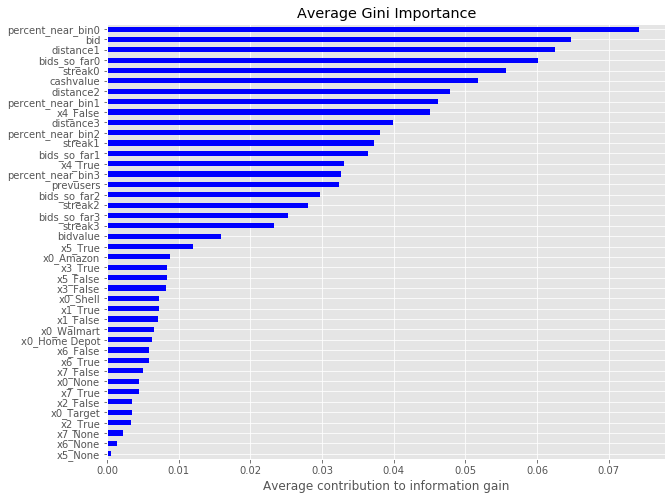

In [165]:
# Plot the feature importance
feat_scores = pd.Series(model.steps[1][1].feature_importances_,
                           index=get_column_names_from_ColumnTransformer(model.named_steps['preprocessor']))
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [166]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [167]:
probs = model.predict_proba(X_test)[:, 1]

In [168]:
for thresh in np.arange(.5, 1,  .05):
    y_to_score = probs > thresh
    cm = confusion_matrix(y_test, y_to_score)
    print("*****************************")
    print("thresh:", thresh)
    print ("Accuracy {}: Precision: {}  Recall:{} ".format(accuracy_score(y_test, y_to_score), precision_score(y_test, y_to_score), recall_score(y_test, y_to_score)))
    print(cm)
    profit = sum(X_test.cashvalue[(y_to_score==True)&(y_test==True)])-sum(y_to_score)*.40
    profit_per_bid = profit/len(y_to_score)
    print("profit:", profit)
    print("profit per bid:", profit_per_bid)
    print("*****************************")
    print("")
    


*****************************
thresh: 0.5
Accuracy 0.7340534052102043: Precision: 0.008694710040900349  Recall:0.7025607353906763 
[[1010702  365980]
 [   1359    3210]]
profit: -14953.0
profit per bid: -0.010825693519859896
*****************************

*****************************
thresh: 0.55
Accuracy 0.785115087699484: Precision: 0.00992423505579238  Recall:0.647625300941125 
[[1081482  295200]
 [   1610    2959]]
profit: 485.3999999999942
profit per bid: 0.00035142056005750885
*****************************

*****************************
thresh: 0.6000000000000001
Accuracy 0.8298817521218084: Precision: 0.011280093329091101  Recall:0.5819654191289122 
[[1143616  233066]
 [   1910    2659]]
profit: 10633.0
profit per bid: 0.007698093974230607
*****************************

*****************************
thresh: 0.6500000000000001
Accuracy 0.8694900492379734: Precision: 0.01270260375642064  Recall:0.5012037644998906 
[[1198694  177988]
 [   2279    2290]]
profit: 15612.800000000003


In [145]:
y_to_score = probs > .7


In [147]:
len(y_test)

1385997

In [87]:
np.arange(0, 5,  .5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [148]:
np.sum(y_to_score)

128957

(array([50., 54., 46., ...,  0.,  0.,  1.]),
 array([1.00000000e+00, 1.99941486e+00, 2.99882972e+00, ...,
        1.70700117e+03, 1.70800059e+03, 1.70900000e+03]),
 <a list of 1709 Patch objects>)

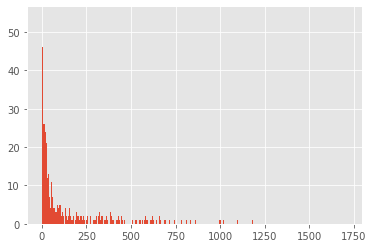

In [149]:
plt.hist(X_test.bid[(y_to_score==True)&(y_test==True)], bins=max(X_test.bid[(y_to_score==True)&(y_test==True)]))

(0, 20)

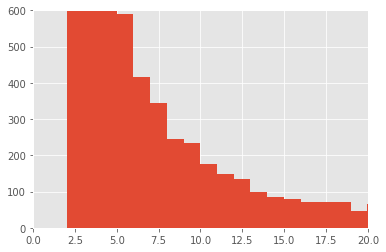

In [174]:
fig, ax = plt.subplots()
ax.hist(X_test.bid[(y_to_score==True)], bins=max(X_test.bid[(y_to_score==True)]))
ax.set_ylim(bottom=0, top=600)
ax.set_xlim(left=0, right=20)